## Primary Type Prediction Based on Pokemon Stats

Ashley Choo, Jonah Marshall, William Li, Sarah Masri

## Introduction

Pokémon is a role-playing game series where you, as a trainer, catch pokemon to battle with other pokemon trainers in a quest to be the best. The strength of a pokemon is determined by its stats, with each pokemon having its own Special Attack, Attack, Special Defense, Defense, Speed, and Hit Points values. Included in the game is a “rock-paper-scissors” advantage system based on a Pokemon’s type. There are 18 different types a Pokemon can have. For example, Fire is strong against Grass, Grass is strong against Water, Water is strong against Fire. Or, Normal type is resistant to Ghost, but vulnerable to Fighting (Tapsell). We will observe a data set of 721 unique Pokémon sourced from kaggle. 

## Predictive Question : Can primary Pokemon type be predicted by given numerical base stats and values?

We want to predict the primary type of a pokemon using the following elements from our data set: hp, speed, defense, special defense, attack, and special attack. We chose to use individual values instead of total because the resulting trends in the data will allow us to more accurately predict the primary type of a pokemon. Since we want to predict a categorical variable using quantitative data, we will use a classification model to conduct our data analysis. In short, we will test and train our data, and examine folds of our data as we have in Chapter 7. We will examine our results by observing the accuracies of our testing set. 

We expect to find correlation between specific type and stats. For example, flying types typically have higher speed compared to others, while normal types may have lower defense. The findings may impact the future generations, as we could predict the stats of each type. The data can also be used to predict well-rounded pokemon types from the players point of view. For example, one type may have more skewed stats (ex. stronger attack, weaker defense) while another type may have more well-rounded and consistent stats. Additionally, if there was a specific type that had statistical advantages because its stats were too strong and had little opposition, then a potential new type may be introduced in the future with stats to counter the over-powered existing types. Down the road, the data can be used to find and produce more types that are different than the existing ones based on specific stats.

## Exploratory Data Analysis
Next, we read will read out data. 

In [4]:
install.packages('gsheet')
install.packages('ggbeeswarm')

library(tidyverse)
library(repr)
library(tidymodels)
library(gsheet)
library(ggbeeswarm)

options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [5]:
pokemon_data <- gsheet2tbl("https://docs.google.com/spreadsheets/d/1fqtgNRjqiDdtTuMV6ZV9GQd48qUavEysdpe35q05EL8/edit?usp=sharing")
colnames(pokemon_data) <- c("index", "name", "type_1", "type_2", "total", "hp",
                                                          "attack", "defense", "sp_attack", "sp_def", "speed",
                                                          "generation", "legendary")
pokemon_data

#Forward Declare for later
#Custom color palate to match the colors from the game.
pokemon_colors <- c('Normal' = '#A8A77A', 
                              'Fire' = '#EE8130', 
                              'Water' = '#6390F0', 
                              'Electric' = '#F7D02C', 
                              'Grass' = '#7AC74C', 
                              'Ice' = '#96D9D6', 
                              'Fighting' = '#C22E28', 
                              'Poison' = '#A33EA1', 
                              'Ground' = '#E2BF65', 
                              'Flying' = '#A98FF3', 
                              'Psychic' = '#F95587',
                              'Bug' = '#A6B91A', 
                              'Rock' = '#B6A136',
                              'Ghost' = '#735797',
                              'Dragon' = '#6F35FC', 
                              'Dark' = '#705746',
                              'Steel' = '#B7B7CE',
                              'Fairy' = '#D685AD')

index,name,type_1,type_2,total,hp,attack,defense,sp_attack,sp_def,speed,generation,legendary
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>
1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,FALSE
2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,FALSE
3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,FALSE
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,TRUE
720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,TRUE
721,Volcanion,Fire,Water,600,80,110,120,130,90,70,6,TRUE


                                           Table 1

Note that type_1 corresponds to the primary type and type_2 corresponds to the secondary type of Pokemon in the dataset. The primary type of a Pokemon is the more defining attribute while the secondary type is a niche factor. We choose to use type_1 (primary type) because the primary type is what defines a Pokemon the most.

Now, identify any pieces of missing data, and where in our data set they occur.

In [6]:
sum(is.na(pokemon_data))

types <- pokemon_data %>% 
    group_by(type_2) %>% 
    summarise(n = n()) %>%
    arrange(desc(n)) %>%
    slice(1:1)
types

[1] 386

`summarise()` ungrouping output (override with `.groups` argument)



type_2,n
<chr>,<int>
NA,386


     Table 2

There are 386 rows with missing data in this dataset, where 386 pokemon are missing data in type_2. However, since type_2 is not relevant to our prediction model, we do not need to worry about it. Next we will confirm number of unique types in our data set and summarize how many pokemon identify with each type. We expect 18 unique types.

Additionally, since we are only considering Primary Type, hp, attack/sp_attack, defense/sp_defense, and speed, we can further clean up our data. 

In [8]:
pokemon_data = pokemon_data %>% select(type_1, hp:speed)

In [9]:
types <- pokemon_data %>% 
    group_by(type_1) %>% 
    summarise(n = n())
#types (changed to print to print out all rows)
print(types, n = Inf)

num_types <- nrow(types)
num_types

`summarise()` ungrouping output (override with `.groups` argument)



# A tibble: 18 x 2
   type_1       n
   <chr>    <int>
 1 Bug         69
 2 Dark        31
 3 Dragon      32
 4 Electric    44
 5 Fairy       17
 6 Fighting    27
 7 Fire        52
 8 Flying       4
 9 Ghost       32
10 Grass       70
11 Ground      32
12 Ice         24
13 Normal      98
14 Poison      28
15 Psychic     57
16 Rock        44
17 Steel       27
18 Water      112


[1] 18

    Table 3

In [10]:
pokemon_stats = pokemon_data %>% 
                select(-type_1)
pokemon_stats

hp,attack,defense,sp_attack,sp_def,speed
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
45,49,49,65,65,45
60,62,63,80,80,60
80,82,83,100,100,80
⋮,⋮,⋮,⋮,⋮,⋮
80,110,60,150,130,70
80,160,60,170,130,80
80,110,120,130,90,70


               Table 4

We choose to use predictors of HP (health points), attack, defense, special attack, special defense, and speed stats because each Pokemon type has the possibility to correlate with a specific stat more than others, which helps us identify and predict the primary type of a Pokemon. All of the predictors are significant to the target variable and question.

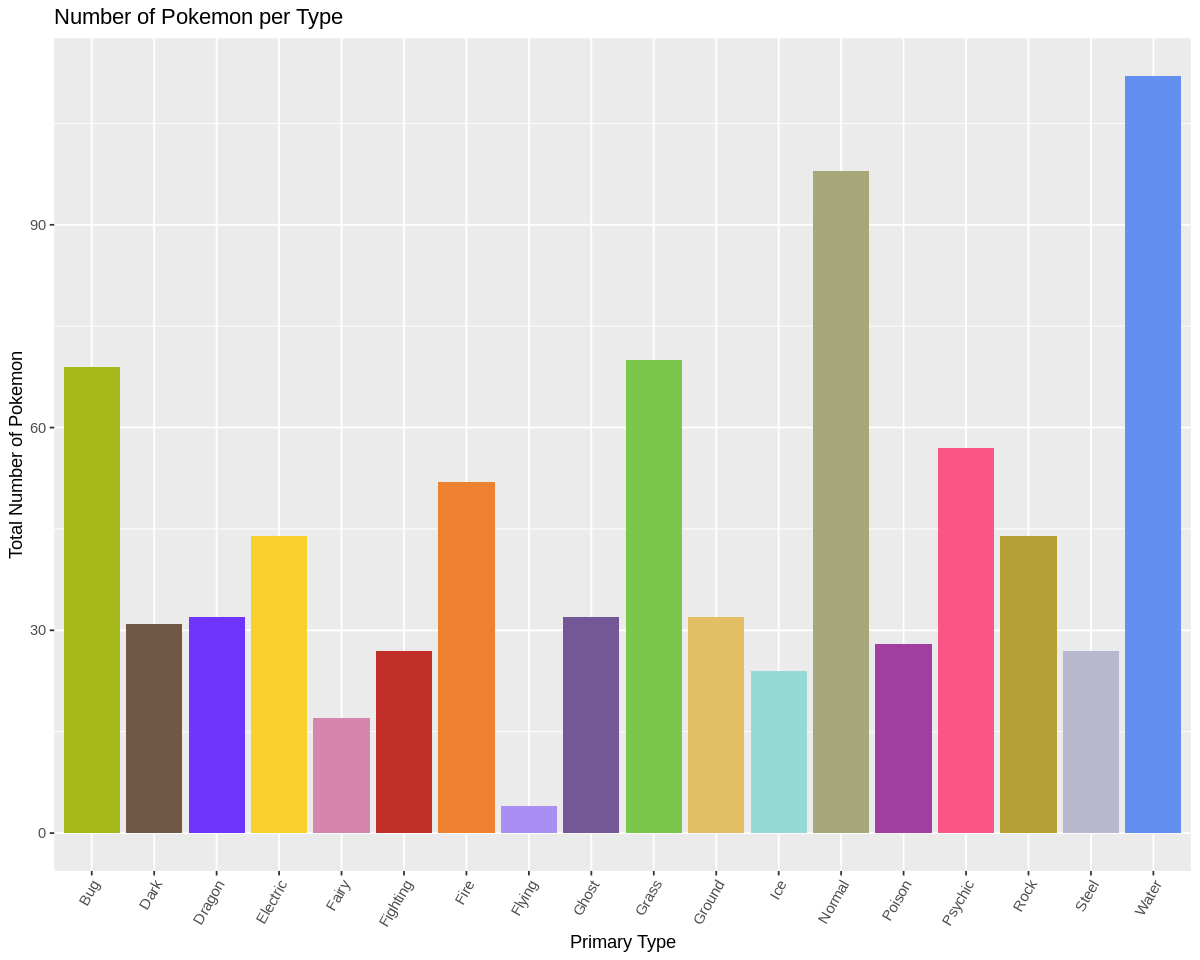

In [11]:
options(repr.plot.width = 10, repr.plot.height = 8) 

pokemon_plot <- types %>% ggplot(aes(x = type_1, y = n, , fill = type_1)) + 
                geom_bar(stat = "identity") +
                scale_fill_manual(values = pokemon_colors) +
                labs(x = "Primary Type", y = "Total Number of Pokemon", title = "Number of Pokemon per Type") +
                theme(axis.text.x = element_text(angle = 60, hjust = 1), legend.position = "none")
pokemon_plot

                                    Figure 5

## Methods

We want to predict the primary type of a pokemon using hp, speed, defense, special defense, attack, and special attack. We chose to use these variables because the potential trends that can be seen in the data will allow us to better predict the primary type of a pokemon. For example, a rock type pokemon may have higher defense stats or lower speed stats of all the pokemon types. Knowing those trends will help us more accurately predict the primary type of a pokemon. We will not use total due to the nature of its calculation. The other values offer specificity that is more applicable to type. Name, index number, and the legendary status of each pokemon are trivially irrelevant for the purposes of our analysis.

Since we want to predict a categorical variable using quantitative data, we will use a classification model to conduct our data analysis. We will test and train our data, and examine folds of our data as we have in Chapter 7. We will create visualization of our results showing how the predicted value for each observation compared to the actual value. 

As shown above, there is no relevant missing data in our dataset. However, we observe from the Number of Pokemon Per Type plot that some types have a much higher representation in our data set than others. For the purpose of our predictive anlysis, we will only consider the five most frequent primary types in our data set. This will ensure a more accurate (or 'fair') in our random split. Additionally, we mutate each primary type as a factor.

Next, we will split our data into a training and testing set and perform a 5-fold cross validition on our training set. Note that we will scale our predictors and add an oversampling step to the data preprocessing to account for classes that are not balanced.

In [12]:
popular_types = pokemon_data %>%
                group_by(type_1) %>% 
                summarise(n = n()) %>%
                arrange(desc(n)) %>%
                slice(1:5)
popular_types

`summarise()` ungrouping output (override with `.groups` argument)



type_1,n
<chr>,<int>
Water,112
Normal,98
Grass,70
Bug,69
Psychic,57


    Table 6

In [13]:
pokemon_data_cleaned = pokemon_data %>%
                     filter(type_1 %in% c("Bug", "Grass", "Normal", "Psychic", "Water")) %>% 
                    mutate(type_1 = as_factor(type_1))
pokemon_data_cleaned 

type_1,hp,attack,defense,sp_attack,sp_def,speed
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Grass,45,49,49,65,65,45
Grass,60,62,63,80,80,60
Grass,80,82,83,100,100,80
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Water,71,73,88,120,89,59
Psychic,80,110,60,150,130,70
Psychic,80,160,60,170,130,80


                    Table 7

In [14]:
set.seed(1234)

pokemon_split = initial_split(pokemon_data_cleaned, prop = 0.75, strata = type_1)
pokemon_training = training(pokemon_split)
pokemon_testing = testing(pokemon_split)

In [15]:
set.seed(1234)

pokemon_split2 = initial_split(pokemon_training, prop = 0.75, strata = type_1)
pokemon_subtrain = training(pokemon_split2)
pokemon_validation = testing(pokemon_split2)

pokemon_vfold = vfold_cv(pokemon_training, v = 5, strata = type_1)
    
pokemon_recipe2 = recipe(type_1 ~ hp + attack + defense + sp_attack + sp_def + speed, data = pokemon_subtrain) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 

pokemon_spec2 = nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
    set_engine("kknn") %>%
    set_mode("classification")

pokemon_results = workflow() %>%
    add_recipe(pokemon_recipe2) %>%
    add_model(pokemon_spec2) %>%
    tune_grid(resamples = pokemon_vfold, grid = 10) %>%
    collect_metrics()

accuracies = pokemon_results %>%
    filter(.metric == "accuracy")
accuracies


neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.3147077,5,0.02403379,Model1
3,accuracy,multiclass,0.3859998,5,0.01239378,Model2
5,accuracy,multiclass,0.4242799,5,0.01565850,Model3
⋮,⋮,⋮,⋮,⋮,⋮,⋮
11,accuracy,multiclass,0.3887830,5,0.02767317,Model5
13,accuracy,multiclass,0.3924337,5,0.02665837,Model6
14,accuracy,multiclass,0.3760897,5,0.02302999,Model7


                        Table 8

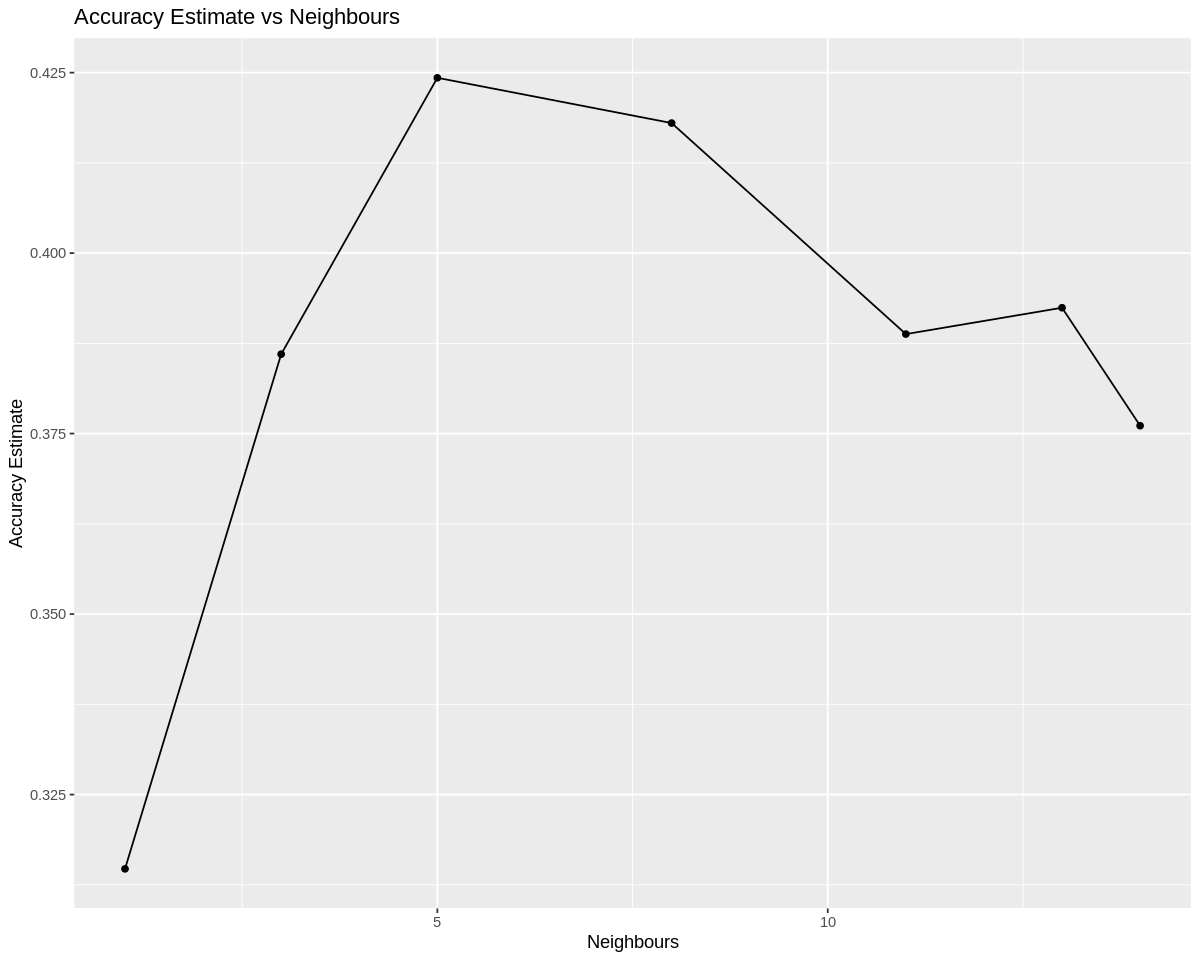

In [17]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy Estimate", title = "Accuracy Estimate vs Neighbours")
accuracy_vs_k

                                    Figure 9

By the Accuracy Estime vs Neighbours plot above (Figure 9), using five neighbours will yield the highest prediction accuracy. Using this information, we can now build our model. 

In [18]:
set.seed(1234)

pokemon_spec = nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
    set_engine("kknn") %>%
    set_mode("classification")
pokemon_spec

pokemon_recipe = recipe(type_1 ~ hp + attack + defense + sp_attack + sp_def + speed, data = pokemon_training) %>%
    step_scale(all_predictors()) %>%
    step_center(all_predictors()) 
pokemon_recipe

pokemon_fit = workflow() %>%
    add_recipe(pokemon_recipe) %>%
    add_model(pokemon_spec) %>%
    fit(data = pokemon_training)

pokemon_fit

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  neighbors = 5
  weight_func = rectangular

Computational engine: kknn 


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          6

Operations:

Scaling for all_predictors()
Centering for all_predictors()

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = ~5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.6013072
Best kernel: rectangular
Best k: 5

## Results
Finally, we will test the accuracy of our model on our testing set. We will print a table of our predictions and metrics, as well as a confusion matrix to better analyse our results.

In [19]:
pokemon_predict = predict(pokemon_fit, pokemon_testing) %>% bind_cols(pokemon_testing)
pokemon_predict

.pred_class,type_1,hp,attack,defense,sp_attack,sp_def,speed
<fct>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Water,Grass,80,82,83,100,100,80
Water,Grass,80,100,123,122,120,80
Normal,Bug,40,35,30,20,20,50
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Water,Grass,88,107,122,74,75,64
Bug,Bug,45,22,60,27,30,29
Psychic,Psychic,74,48,76,83,81,104


                       Table 10

In [20]:
pokemon_metrics <- pokemon_predict %>%
                    metrics(truth = type_1, estimate = .pred_class) 
pokemon_metrics

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.4700000
kap,multiclass,0.3181526


        Table 11

In [21]:
pokemon_conf_mat <- pokemon_predict %>% 
       conf_mat(truth = type_1, estimate = .pred_class)
pokemon_conf_mat

          Truth
Prediction Grass Water Bug Normal Psychic
   Grass       2     4   1      2       2
   Water       7    16   3      5       5
   Bug         4     2  10      2       2
   Normal      2     4   3     14       0
   Psychic     2     2   0      1       5

                Table 12

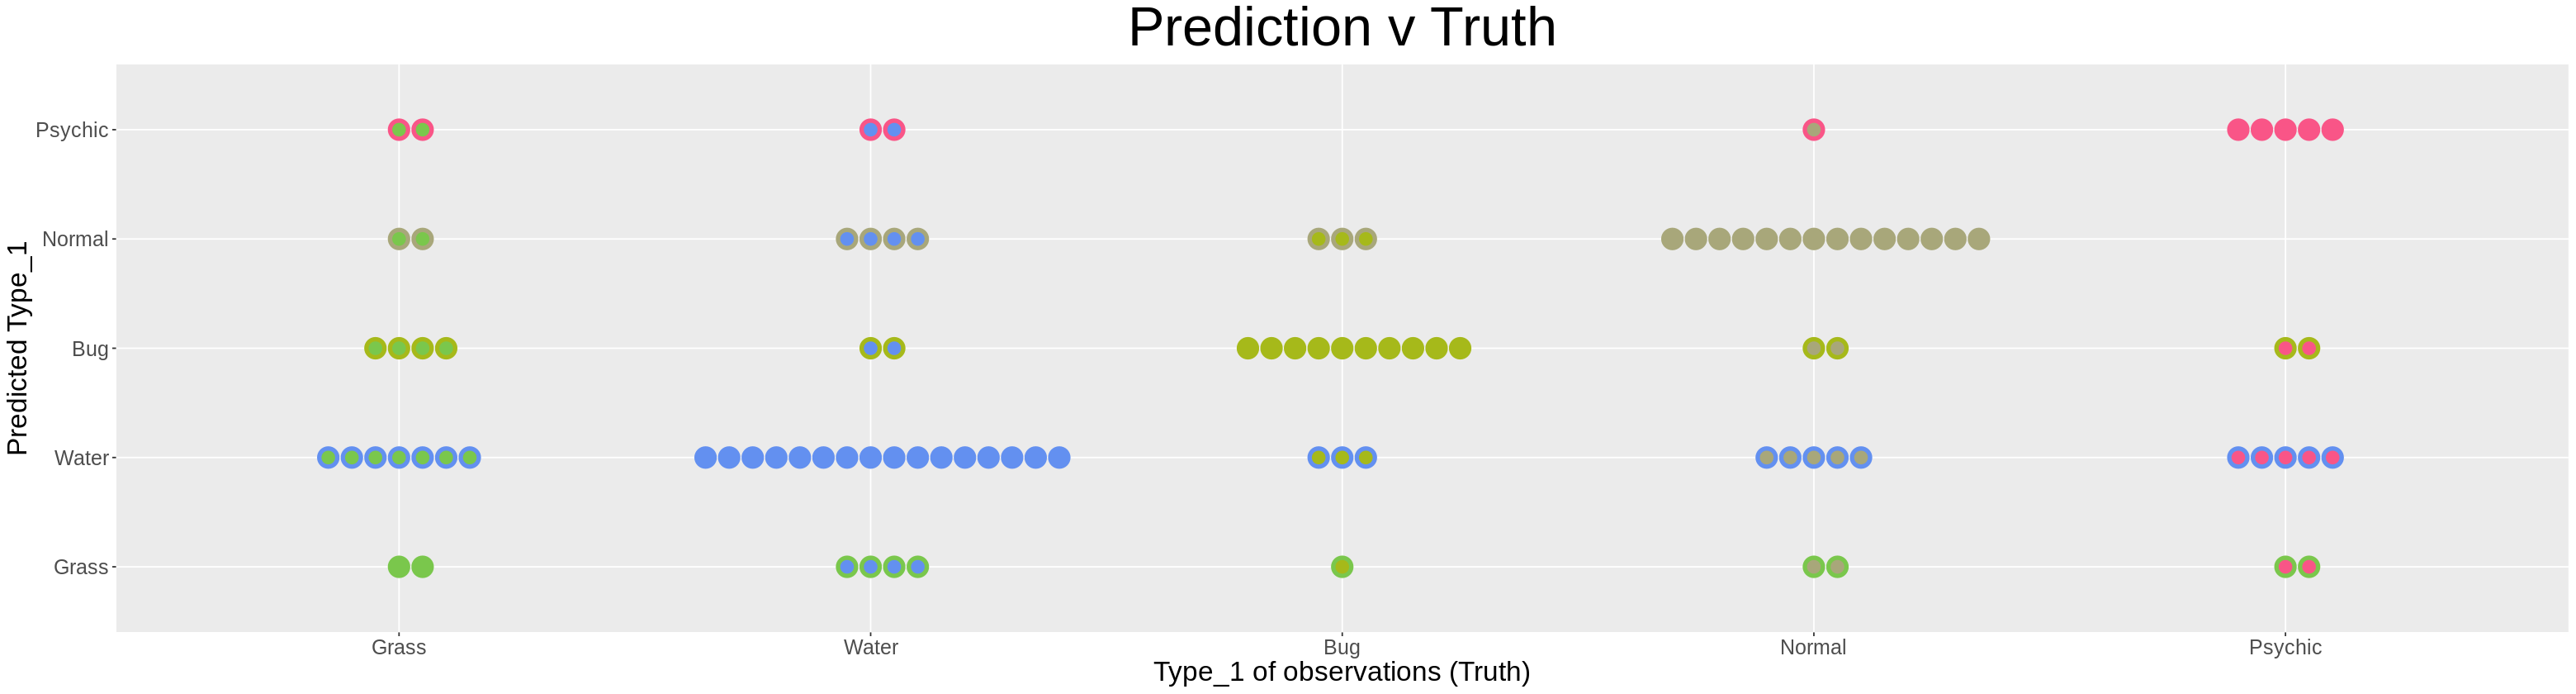

In [33]:
options(repr.plot.width = 26, repr.plot.height = 7)
result_plot <- ggplot(pokemon_predict, aes(x = type_1, y = .pred_class, color = type_1)) + 
                geom_beeswarm(groupOnX = TRUE, size = 7, inherit.aes = FALSE, aes(x = type_1, y = .pred_class, color = .pred_class)) + #Creates outer ring of what we predicted type_1 to be
                geom_beeswarm(groupOnX = TRUE, size = 4) + #Functions as a "Fill" for what the actual type_1 was
                scale_color_manual(values = pokemon_colors) +
                labs(x = "Type_1 of observations (Truth)", y = "Predicted Type_1", title = "Prediction v Truth") +
                theme(legend.position = "none", #coloring is based off x & y identity, legend does not add clarity
                      plot.title = element_text(size = 40, hjust = 0.5), #Text Size and positioning to help with readability
                      axis.text.x = element_text(size = 15),
                      axis.text.y = element_text(size = 15),
                      axis.title.x = element_text(size = 20),
                      axis.title.y = element_text(size = 20)) 


result_plot

                                                                                     Figure 13

## Discussion

We have visualized our confusion matrix (Table 12) in the plot above (Figure 13). The color of the circumference represents each observations prediction class, and the color of the center represents the observations true value. It is clear that the upward diagonal of our plot indicates the predictions from our model that were identical to an observations true label. This contributes to the dialogue given by our other results (including the Pokemon metrics and confusion matrix) that our model is not entirely reliable. Our accuracy estimate ended up at 47%, which is unreliable and lower than we had anticipated. 

Our findings indicate that a pokemon's primary type is not necessarily dictated by its stats. This may contribute to a Pokemon players game play, or other Pokemon game theorists, in how they play the game. 

Since our model shows that we cannot sufficiently predict primary type based on the stats alone we want to look at potentional reasons why our accuracies are low to decide what types of future studies we could try. An interesting remark to take note of is that when visualised we can see that there were no predictions for "Bug" being "Psychic" or "Psychic" being "Normal". This suggests that there could be discernable differences in stats between multiple types and that our selection of the five most frequent primary types is not representative of the ability to differentiate all primary types. 

Our low accuracies estimate could be caused by multiple factors in how we used our data. Due to there being pokemon with low total stats and high total stats that are the same type, our model may be looking at too broad of a range in numbers for trying to predict type. If we mutate our data (beyond scaling) so that all our predictor variables are divided by the pokemon's total stats we look at how stats proportionally distributed rather than the values we will have smaller ranges for the model to use. By doing this our low stat total pokemon will be easily compareable to the high stat total ones. Another alternative would be to sort the data by total stats and attempt the classification on a head() from each type_1 so that you're either looking at only pokemon with comparable total stats.

Additionally, we eliminated a variety of statistics from our data set. Namely, we did not consider a pokemon's genration in our model. In the future, we may consider how a one could predict primary type given the numerical base values while considering "Pokemon Generation" (values 1:6). The inclusion of a “Pokemon Generation” column is important to this data set since Generation 1 was designed in 1996 whereas Generation 6 was in 2013. Due to game developers wanting to balance the game, if one specific type of pokemon underperformed in one generation, we may expect their stats to be higher in the next. If they continued to take the approach of “buffing” or raising the stats of under performers, over time the overall stats of pokemon would increase.

We believe that the best study to do based of our results would be re-attempting our same predictive question using the propotion of stat allocation method. Depending on the results of that study we would be able to ask questions like "Can you predict dual-type" ie. type_2 not NA. 

## References

&nbsp;&nbsp;&nbsp;&nbsp; Barradas, Alberto. “Pokemon with Stats.” Kaggle, 29 Aug. 2016, www.kaggle.com/abcsds/pokemon.

&nbsp;&nbsp;&nbsp;&nbsp; Tapsell, Chris. “Pokémon Go Type Chart, Type Effectiveness and Weakness Explained.” Eurogamer.Net, 13 May  2020, www.eurogamer.net/articles/2018-12-21-pokemon-go-type-chart-effectiveness-weaknesses.

&nbsp;&nbsp;&nbsp;&nbsp; D. Simões, S. Reis, N. Lau and L. P. Reis, "Competitive Deep Reinforcement Learning over a Pokémon Battling Simulator," 2020 IEEE International Conference on Autonomous Robot Systems and Competitions (ICARSC), Ponta Delgada, Portugal, 2020, pp. 40-45, doi: 10.1109/ICARSC49921.2020.9096092.